In [17]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from pinns.samplers import RandomRectangularSampler, ConstantSampler, DataSampler

path = 'C:/Программы/github/pinns/examples/data/diffusion 1d/'

def get_data(path):
    init = torch.tensor(np.load(path + 'init_data.npy'))
    left = torch.tensor(np.load(path + 'left_data.npy'))
    right = torch.tensor(np.load(path + 'right_data.npy'))
    
    return ([init[:,  :2], left[:,  :2], right[:,  :2]], 
            [init[:, [2]], left[:, [2]], right[:, [2]]])

pts, data = get_data(path)
constraints_sampler = ConstantSampler((pts, data))

''' -- COLLOCATION -- '''

# If our sampler returns tensor with shape [num_pts, num_coords], 
# we must edit our loss function so that it takes not t and x 
# separately, but z instead of shape [1024, 2]. Then we must 
# calculate gradient and use slices to take grad of specific 
# tensors, for example: ```ut = d(u, z)[:, 0]```. But it is very 
# ugly for our demonstration purposes (but much more efficient 
# when number of coordinates is big). We will instead expect 
# from sampler to return dictionary for each coordinate.

domain = {'t': [0, 0.5], 'x': [0, 1]}
collocation_sampler = RandomRectangularSampler(domain, 2048)


''' -- VALIDATION DATA -- '''

# We do not want to load all test points every time, so let's 
# write sampler that gives us either all data points or random 
# subset of them. 1024 is pretty much enough to fine precision.

test_data_sampler = DataSampler(path + 'solution.npy', 1024, 2)

In [20]:
from pinns.derivatives import Derivative

d = Derivative(method='autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    D = 0.5
    ):
    
    # We do not need left and right because we are solving 
    # Dirichlet problem and we just compare predictions and 
    # solution. If we solve Cauchy or Robin problem, we 
    # need to calculate derivatives at boundary points.
    
    init_pts, left_pts, right_pts = cstr_pts
    init_pred, left_pred, right_pred = cstr_pred
    init_vals, left_vals, right_vals = cstr_vals
    
    t, x = coll_pts['t'], coll_pts['x']
    
    def initial_loss():
        return torch.mean(torch.square(init_pred - init_vals))
    
    def left_loss():
        return torch.mean(torch.square(left_pred - left_vals))
    
    def right_loss():
        return torch.mean(torch.square(right_pred - right_vals))
    
    def pde_loss(u, t, x):
        ut  = d(u,  t)
        uxx = d(u,  x, orders = 2)
        return torch.mean(torch.square(ut - D * uxx))
    
    return (
        initial_loss(), 
        left_loss(), 
        right_loss(), 
        pde_loss(coll_pred, t, x)
    )

In [21]:
def get_ip_data(N):
    pts, data = test_data_sampler(full=True)
    
    step = len(pts) // N
    
    return pts[::step, :], data[::step, :]

def get_dists(pts, A = 0, B = 1):
    init_dists  = pts[:,0]
    left_dists  = (pts[:,1] - A).abs()
    right_dists = (pts[:,1] - B).abs()
    dists = torch.stack([init_dists, left_dists, right_dists]).T
    return dists.min(dim=1).values

ip_pts, ip_vals = get_ip_data(1000)
dists = get_dists(ip_pts)

In [22]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Swish
from pinns.optimizers import Adam
from pinns.metrics import l2

pinn = FF([2, 64, 64, 1], activ=nn.Tanh())

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs = [0.75, 0.75, 0.75, 0.25],
)

num_iters = 5000

errors = []
def save_error():
    if trainer.iter == 0 or (trainer.iter + 1) % 25 == 0:
        preds = pinn(ip_pts).detach()
        error = (preds - ip_vals).abs().flatten()
        errors.append(error)
    
trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    validate_every=1,
    metrics=[l2],
    test_sampler = test_data_sampler,
    training_start_callbacks = [save_error],
    epoch_end_callbacks = [save_error]
    )

  0%|          | 0/5000 [00:00<?, ?it/s]

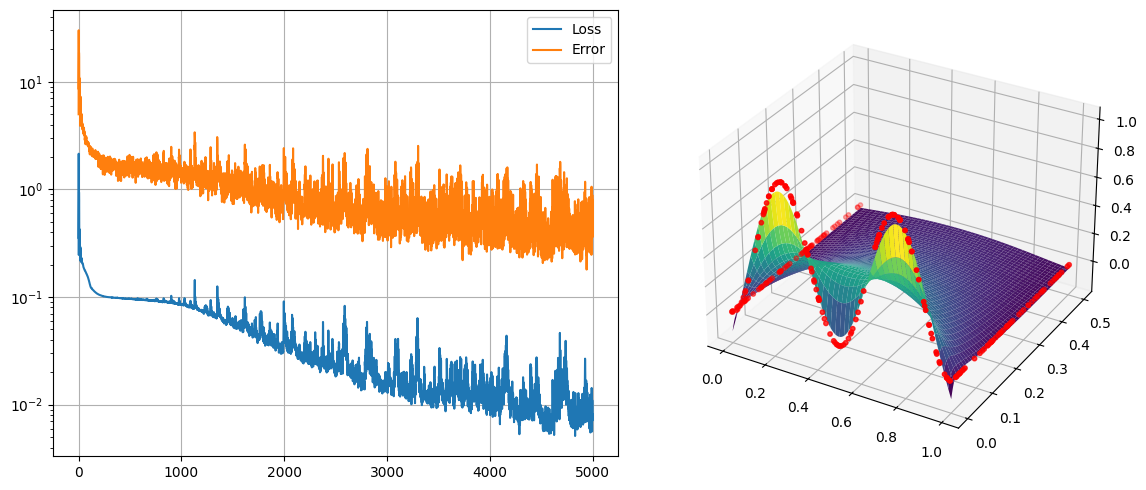

In [23]:
# We know the shape of test data.
Nt, Nx = 500, 150
pts, values = test_data_sampler(full=True)

pts = [
    pts[:,0].reshape(Nx, Nt),
    pts[:,1].reshape(Nx, Nt)
]
values = values.reshape(Nx, Nt)

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)
ax.plot(trainer.loss_history, label='Loss')
ax.plot(range(0, trainer.iter + 1, 1), trainer.error_history, label='Error')
ax.grid()
ax.set_yscale('log')
ax.legend()

preds = pinn.predict(test_data_sampler(full=True)[0]).detach().reshape(Nx, Nt)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(pts[1], pts[0], preds, cmap='viridis')

# We also plot constraints as red dots.
cstr_pts, cstr_vals = constraints_sampler()
stacked_pts = torch.cat([torch.hstack([t[:, [1]], t[:, [0]]]) for t in cstr_pts])
stacked_vals = torch.cat(cstr_vals)
constraints = torch.hstack([stacked_pts, stacked_vals.reshape(-1, 1)]).T
ax.scatter3D(*constraints, color='r', s=10)
# ax.view_init(80, -120)

plt.tight_layout()
plt.show()

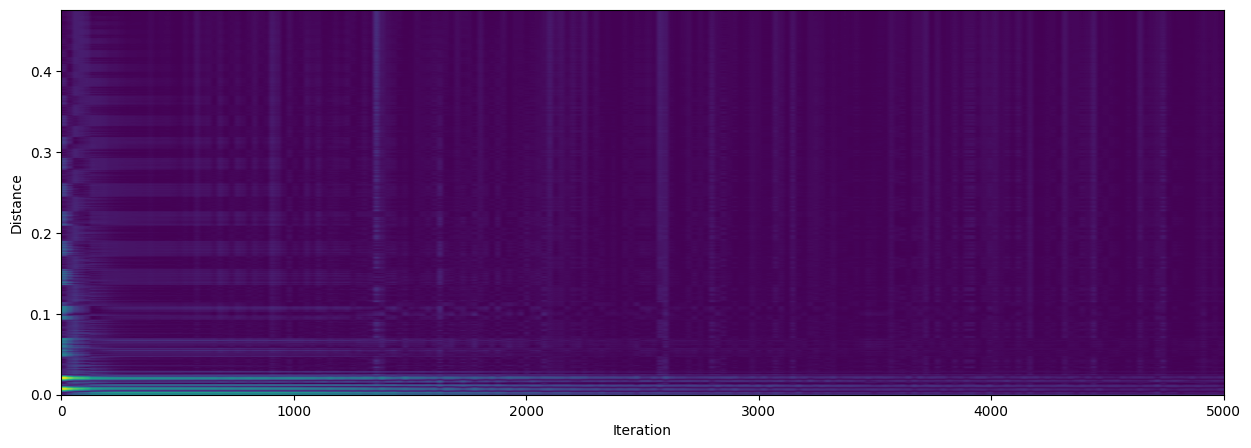

In [24]:
fig = plt.figure(figsize=(15, 5))

stacked_errors = torch.vstack([
    dists, *errors
]).T.numpy()
sorted_errors = stacked_errors[stacked_errors[:, 0].argsort()]

plt.imshow(sorted_errors[:,1:], aspect='auto', origin='lower', extent=[0, trainer.iter, 0, dists.max()])

plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.show()